# Part 3: Visualise

Firstly, we visualise the performance of the case with the best clustering results, as seen in the
previous part. We set the reduction dimension values according to the the optimised values we
got, which are: 200 for truncated SVD, 3 for PCA, and 2 for NMF (Non-logarithmic). In order to
make the clustering results easier to understand, we can plot the data points with different colors
and shapes, which stand different for the ground-truth label and the algorithm-clustered label.

In [1]:
from sklearn.datasets import fetch_20newsgroups
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from math import log
import matplotlib.pyplot as plt
import re


## Loading data

In [2]:
#Loading data
comp_subclasses=['comp.graphics','comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware','comp.sys.mac.hardware']
rec_subclasses=['rec.autos','rec.motorcycles','rec.sport.baseball','rec.sport.hockey']
  
data=fetch_20newsgroups(subset='all',categories=comp_subclasses+rec_subclasses,shuffle=True,random_state=42,
                        remove=('headers','footers','quotes'))

labels=[1]*len(data.data)
for i in range(len(data.data)):
    if data.target[i]>3:
        labels[i]=0

## Preprocessing the data

In [3]:
#Preprocessing the data by stripping off punctuations, removing stopwords, and stemming (it betters the performance, so we've included it)
punctuations='[! \" # $ % \& \' \( \) \* + , \- \. \/ : ; <=> ? @ \[ \\ \] ^ _ ` { \| } ~]'
stemmer=SnowballStemmer("english")
def remove_punctuation_and_stem(data_list):
    for i in range(len(data_list)):
        data_list[i]=" ".join([stemmer.stem(data) for data in re.split(punctuations,data_list[i])])
        data_list[i]=data_list[i].replace('\n','').replace('\t','').replace('\r','')
remove_punctuation_and_stem(data.data)


## Getting TF-IDF matrix

In [4]:
#Getting the TFxIDF matrix representation using min_df=3
vectorizer=TfidfVectorizer(max_features=10000,min_df=3,stop_words='english',use_idf=True)
X=vectorizer.fit_transform(data.data)
print(X.shape)

(7882, 10000)


## Making a function to plot clusters

In [5]:
#Plotting required results
def plot_clusters(actual_labels,clustered_labels,X_2d,centers,reducer):
    color=["r","b"]
    mark=["+","o"]
    for i in range(len(labels)):
        plt.scatter(X_2d[i,0],X_2d[i,1],s=12,marker=mark[actual_labels[i]],color=color[clustered_labels[i]],alpha=0.5)
    for i in range(2):
        plt.scatter(centers[i,0],centers[i,1],marker='^',s=100,linewidths=5,color='k',alpha=0.6)
    plt.title('Clustering results with ' + reducer)
    plt.show()

## Use K-means algorithm

In [6]:
km=KMeans(n_clusters=2,init='k-means++',max_iter=100,n_init=1)

**For the optimised case, the dimension of the final TF-IDF matrix is larger than 3, but we can
only plot nodes upto 3 dimensions. So, a solution for this, is to use the optimized dimension
reduction to process the TF-IDF matrix, and then apply the K-means algorithm. This would
re-reduce the matrix to 2-dimension to plot the graph.**

## Reduce dimensionality using SVD and plotting clusters

In [7]:
#Reduce dimensionality using SVD: best r value comes out to be 200, with n_iter=13
print('Performing truncatedSVD')
svd=TruncatedSVD(n_components=200,n_iter=13,random_state=42)
normalizer=Normalizer(copy=False)
lsa=make_pipeline(svd,normalizer)
X_reduced=lsa.fit_transform(X)

Performing truncatedSVD


In [8]:
km.fit(X_reduced)
clustered_labels=km.labels_

svd=TruncatedSVD(n_components=2,n_iter=13,random_state=42)
X_2d=svd.fit_transform(X)
km.fit(X_2d)
centers=km.cluster_centers_

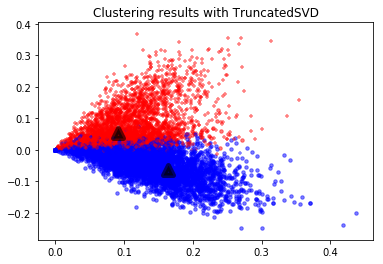

In [9]:
plot_clusters(labels,clustered_labels,X_2d,centers,'TruncatedSVD')

**In the plot of truncated SVD, we can see that the data points are distributed in a triangle-like
shape, and the ground-truth labels are approximately separated along the left angle bisector,
where the labels of data points above and below are likely different. Also, from the color, we can
see that, except for some false clustering near the bisector, the K-means algorithm separated the
data points along the bisector as well, which is consistent with the confusion matrix we inspected
before.**

## Reduce dimensionality using PCA and plotting its clusters

In [10]:
#Reduce dimensionality using PCA: best r value comes out to be 3
print('Performing PCA')
pca=PCA(n_components=3,random_state=42)
normalizer=Normalizer(copy=False)
lsa=make_pipeline(pca,normalizer)
X_reduced=lsa.fit_transform(X.toarray())

km.fit(X_reduced)
clustered_labels=km.labels_

pca=PCA(n_components=2,random_state=42)
X_2d=pca.fit_transform(X.toarray())
km.fit(X_2d)
centers=km.cluster_centers_

Performing PCA


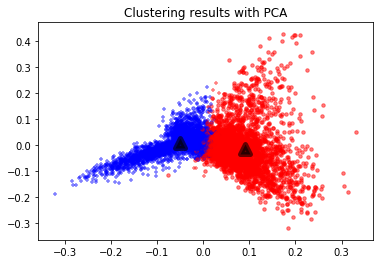

In [11]:
plot_clusters(labels,clustered_labels,X_2d,centers,'PCA')

**As for PCA reduction, the data points are distributed in an arrow-head-like shape. The K-means
algorithm separated them along the top bisector, which is also approximately the partition of the
ground truth.**

## Reducing Dimensionality using NMF without non-linear transformation and plotting its clusters

In [12]:
#Reduce dimensionality using NMF: best r value comes out to be 2
print('Performing NMF without any non-linear transformation')
nmf=NMF(n_components=2,random_state=42)
lsa=make_pipeline(nmf)
X_reduced=lsa.fit_transform(X)

km.fit(X_reduced)
clustered_labels=km.labels_
centers=km.cluster_centers_



Performing NMF without any non-linear transformation


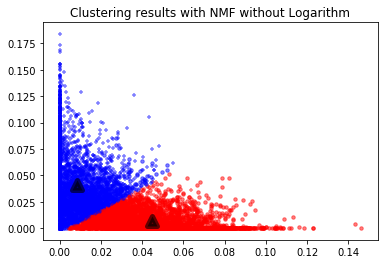

In [13]:
plot_clusters(labels,clustered_labels,X_reduced,centers,'NMF without Logarithm')

**In the plot for NMF reduction, the data points are mostly distributed beneath the (1/x) curve in
the plot, while the ground-truth labels are approximately separated along the bisector of the
90-degree angle, with a considerable amount of false. When the NMF reduction is applied
without the logarithmic transformation, the K-means algorithm separated the data points along
the bisector almost linearly, and therefore produced some false clustering points near the
bisector.**

## Performing non-linear transformation on data for NMF method

Next, we apply normalization and non-linear transformations to the reduced TF-IDF matrix, in
order to get better precision. We observed that only the normalization, or the non-linear
transformation, improves the clustering completeness only by a little margin, but when
combined, the results are significantly better.

For the non-linear transformation, we use logarithmic transformation. Here, we must be careful
with the zeroes in the original matrix, when performing the transformation, since the logarithm
of 0 is undefined. But we cannot simply ignore the zeroes in the original matrix, because
logarithm of 1 is 0. Therefore, if we ignore the zeroes, all the 0s and 1s will become 0s after the
transformation. This will severely change the information stored in the original matrix. We solve
this by replacing the original zeroes with some positive value, so that they can be processed by
the logarithm operation, while the information in the matrix is retained.

By sweeping through the
dimension values, the best results were observed with r=10, as shown below:

In [17]:
from sklearn import metrics

In [18]:
#Performing K-Means Clustering
def k_means(X_reduced,labels,dim_reduce):

    km=KMeans(n_clusters=2,init='k-means++',max_iter=100,n_init=1)
    km.fit(X_reduced)

    #Printing the required measures for comparison of different clustering results
    print('Dimensionality Reduction method:',dim_reduce)
    print('Homogeneity:',metrics.homogeneity_score(labels,km.labels_))
    print('Completeness:',metrics.completeness_score(labels,km.labels_))
    print('V-Measure:',metrics.v_measure_score(labels,km.labels_))
    print('Adjusted Rand Score:',metrics.adjusted_rand_score(labels,km.labels_))
    print('Adjusted Mutual Info Score:',metrics.adjusted_mutual_info_score(labels,km.labels_))
    print('Confusion matrix:')
    print(metrics.confusion_matrix(labels,km.labels_))
    print('\n\n\n')

In [20]:
#Reduce dimensionality using NMF having the logarithmic transformation, best r value comes out to be 10
for i in [1,2,3,5,10,20,50,100]:
    print('Performing NMF (with the non-linear logarithmic transformation) with',i,'components')
    nmf=NMF(n_components=i,random_state=42)
    lsa=make_pipeline(nmf)
    X_reduced=lsa.fit_transform(X)

    #----------------------------Non-linear Transformation-------------------------
    for j in range(X_reduced.shape[0]):
        for k in range(X_reduced.shape[1]):
            if X_reduced[j][k] == 0:
                X_reduced[j][k]=-3.08
            else:
                X_reduced[j][k]=log(X_reduced[j][k],10)
    #------------------------------------------------------------------------------
    k_means(X_reduced,labels,'NMF')

Performing NMF (with the non-linear logarithmic transformation) with 1 components
Dimensionality Reduction method: NMF
Homogeneity: 0.0022860045532073297
Completeness: 0.007420548034947289
V-Measure: 0.003495248481089873
Adjusted Rand Score: 0.00018900104531209116
Adjusted Mutual Info Score: 0.0021945753097493545
Confusion matrix:
[[3709  270]
 [3738  165]]




Performing NMF (with the non-linear logarithmic transformation) with 2 components


C:\Users\Omkar Mehta\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


Dimensionality Reduction method: NMF
Homogeneity: 0.4296465259163744
Completeness: 0.4429771898308768
V-Measure: 0.43621003471824116
Adjusted Rand Score: 0.5004011162101343
Adjusted Mutual Info Score: 0.42959430932270526
Confusion matrix:
[[ 194 3785]
 [2944  959]]




Performing NMF (with the non-linear logarithmic transformation) with 3 components


C:\Users\Omkar Mehta\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


Dimensionality Reduction method: NMF
Homogeneity: 0.07160193875139846
Completeness: 0.07380056868991325
V-Measure: 0.07268463098941277
Adjusted Rand Score: 0.09446486022567353
Adjusted Mutual Info Score: 0.07151694272524163
Confusion matrix:
[[ 984 2995]
 [2158 1745]]




Performing NMF (with the non-linear logarithmic transformation) with 5 components


C:\Users\Omkar Mehta\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


Dimensionality Reduction method: NMF
Homogeneity: 0.4183309319800348
Completeness: 0.4184036193120157
V-Measure: 0.4183672724888422
Adjusted Rand Score: 0.5203434166361898
Adjusted Mutual Info Score: 0.4182776800104868
Confusion matrix:
[[3375  604]
 [ 494 3409]]




Performing NMF (with the non-linear logarithmic transformation) with 10 components


C:\Users\Omkar Mehta\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


Dimensionality Reduction method: NMF
Homogeneity: 0.4891522542694507
Completeness: 0.4918577590040144
V-Measure: 0.49050127591239245
Adjusted Rand Score: 0.5906736167897778
Adjusted Mutual Info Score: 0.4891054859239196
Confusion matrix:
[[3677  302]
 [ 610 3293]]




Performing NMF (with the non-linear logarithmic transformation) with 20 components


C:\Users\Omkar Mehta\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


Dimensionality Reduction method: NMF
Homogeneity: 0.4173220284049291
Completeness: 0.4188979805665512
V-Measure: 0.41810851945477395
Adjusted Rand Score: 0.517053439411324
Adjusted Mutual Info Score: 0.41726868400226336
Confusion matrix:
[[3550  429]
 [ 678 3225]]




Performing NMF (with the non-linear logarithmic transformation) with 50 components


C:\Users\Omkar Mehta\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


Dimensionality Reduction method: NMF
Homogeneity: 0.43917888045743075
Completeness: 0.4427490664129021
V-Measure: 0.44095674709212906
Adjusted Rand Score: 0.5358351261982848
Adjusted Mutual Info Score: 0.4391275369795245
Confusion matrix:
[[3641  338]
 [ 718 3185]]




Performing NMF (with the non-linear logarithmic transformation) with 100 components


C:\Users\Omkar Mehta\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


Dimensionality Reduction method: NMF
Homogeneity: 0.28049043211983454
Completeness: 0.2815048548360177
V-Measure: 0.2809967279422705
Adjusted Rand Score: 0.35912755735736274
Adjusted Mutual Info Score: 0.2804245607332017
Confusion matrix:
[[ 949 3030]
 [3273  630]]






C:\Users\Omkar Mehta\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


By sweeping through the
dimension values, the best results were observed with r=10

### Plotting the clusters for NMF with non-linear transformation

In [21]:
#Reduce dimensionality using NMF with the logarithmic non-linear transformation: best r value comes out to be 10
print('Performing NMF with the logarithmic non-linear transformation')
nmf=NMF(n_components=10,random_state=42)
lsa=make_pipeline(nmf)
X_reduced=lsa.fit_transform(X)

# ----------------------------Non-linear Transformation-------------------------
for j in range(X_reduced.shape[0]):
    for k in range(X_reduced.shape[1]):
        if X_reduced[j][k] == 0:
            X_reduced[j][k]=-3.08
        else:
            X_reduced[j][k]=log(X_reduced[j][k],10)
# ------------------------------------------------------------------------------

km.fit(X_reduced)
clustered_labels=km.labels_

nmf=NMF(n_components=2,random_state=42)
X_2d=nmf.fit_transform(X)
km.fit(X_2d)
centers=km.cluster_centers_



Performing NMF with the logarithmic non-linear transformation


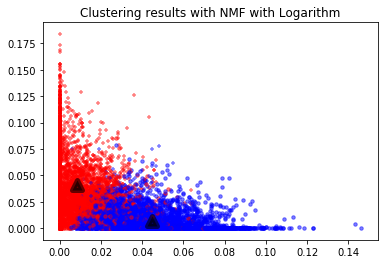

In [22]:
plot_clusters(labels,clustered_labels,X_2d,centers,'NMF with Logarithm')

**As we can see from the result, NMF’s performance is significantly improved by applying both
the transformations. Another advantage to do so, is that the results become very stable, that is,
the results are basically the same, no matter how many times we run the algorithm for the same
dataset, under the same parameters. The reason that this transformation works so good is that, it transforms the unknown type of
problem, into something that we already know, so that the data corresponds better to our
hypothesis. From the point distribution of all the data points, we inferred that if we take the
logarithm of every data point, the distribution of the data points into two clusters will be much
better, which means that K-means has a higher chance of correctly clustering the data. This also
explains why NMF is more stable than other algorithms. We can see from the plot, that the partition is no longer absolutely linear, and some of the falsely
clustered data points are now correctly clustered. This is because the logarithm re-distributed the
data points, and suppressed the error of the algorithm, which was arising from the linear
partition.**